<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 

# [Machine Learning Tutorial](https://github.com/wikistat/MLTraining): IoT and Human Activity Recognition (HAR)
## Analysis of   signals   obtained from a *smartphone* 
## Use of the libraries <a href="http://scikit-learn.org/stable/#"><img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png" style="max-width: 100px; display: inline" alt="Scikit-Learn"/></a> in <a href="https://www.python.org/"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Python_logo_and_wordmark.svg/390px-Python_logo_and_wordmark.svg.png" style="max-width: 120px; display: inline" alt="Python"/></a> and <a href="https://keras.io/"><img src="https://s3.amazonaws.com/keras.io/img/keras-logo-2018-large-1200.png" style="max-width: 100px; display: inline" alt="Keras"/></a> 



### Summary

The data we will study all along this notebook are public data, which were acquired and described by [Anguita et al. (2013)](). They are available on the [bucket](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) of Irvine California University. They represent usecases of Human Activity Recognition from signal recordings (gyroscope, accelerometer) obtained with a smartphone. 
The data are analyzed to illustrate the main steps common in *data science* and applicable to sampled physical signals. Visualization of the raw signals to assess the difficulties posed by this type of data; exploration ([principal component analysis](http://wikistat.fr/pdf/st-m-explo-acp.pdf), [discriminant factor analysis](http://wikistat.fr/pdf/st-m-explo-acp.pdf)) of the transformed (*features*) or *business* data computed from the signals; prediction of the activity from the business data by most linear methods including: [logistic regression](http://wikistat.fr/pdf/st-m-app-rlogit.pdf), [SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf) and nonlinear; activity prediction from raw signals by [neural network](http://wikistat.fr/pdf/st-m-app-rn.pdf) of multilayer perceptron type. 




## 1 Introduction
### 1.1 General objective
The objective is to recognize the activity of an individual carrying a smartphone that records a set of signals from the onboard gyroscope and accelerometer and thus connected. A learning database has been built experimentally. A set of wearers of a smartphone produced a determined activity during a predefined period of time while signals were recorded. The data are from the human activity recognition (HAR) community. See the [article](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2013-11.pdf) reporting on a 2013 conference.  Data analysis associated with real-time activity identification is not addressed.

The available public data were acquired, described and partially analyzed by [Anguita et al. (2013)](https://www.icephd.org/sites/default/files/IWAAL2012.pdf). They are accessible on the [repository](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) at the University California Irvine (UCI) dedicated to machine learning.

The archive contains the raw data: accelerations sampled at 64 htz for 2s. The accelerations in x, y, and z, each of 128 columns, those in y subtracting the natural gravity as well as the angular accelerations (gyroscope) in x, y, and z, that is to say 9 files in all. The choice of a power of 2 for the sampling frequency allows the efficient execution of Fourier transform or wavelet algorithms.


### 1.2 Process
A first visualization and exploration of the raw signals shows (section 2) that they are difficult to analyze; the activity classes are indeed poorly characterized. **The main cause is the lack of synchronization of the activity beginnings; the phase shift of the signals then appears as a noise or artifact very detrimental for a good discrimination of the activities on the basis of a usual Euclidean distance ($L_2$).** This is the reason why [Anguita et al. (2013)](https://www.icephd.org/sites/default/files/IWAAL2012.pdf) propose to compute a set of classical transformations or features (*features*) of signal processing: variance, correlations, entropy, Fourier decompositions... These are then $p=561$ variables which are considered and explored in section 3. The [principal component analysis](http://wikistat.fr/pdf/st-m-explo-acp.pdf) and especially the [discriminant factor analysis](http://wikistat.fr/pdf/st-m-explo-acp.pdf) show the good discriminatory qualities of these feature data resulting from an expert knowledge of the signals. Section 4 exploits these features  and shows that elementary statistical models (logistic regression, discriminant analysis) or a classical support vector machine (SVM) algorithm using a simple linear kernel lead to excellent predictions in contrast to sophisticated non-linear algorithms (*random forest*).

Nevertheless, having sophisticated transformations computed all the time is not a viable solution for the battery of a connected embedded object. The candidate algorithm must be able to produce a solution that can be integrated (wired) into a circuit, as is the case, for example, with chips dedicated to facial recognition. This is the purpose of section 5: to show the feasibility of a solution based on raw signals only; solution using neural networks.


### 1.3 Software environment
To be executed, this notebook (*jupyter notebook*) requires the installation of Python 3 via for example the site [Anaconda](https://conda.io/docs/user-guide/install/download.html). The exploration and statistical learning algorithms used are available in the [`Scikit-learn`] library (http://scikit-learn.org/stable/). 



# <FONT COLOR="Red">Episode 1</font>

## 2 Preliminary study of raw signals
### 2.1 Source

The data are from the [UCI] repository (https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). It can be downloaded beforehand by clicking [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip).

Each record or statistical unit or instance is labeled with **6 activities**: standing, sitting, lying, walking, climbing or descending stairs. Each dataset is split into a training sample and a test sample. The test sample is only used to evaluate and compare the predictive qualities of the main methods. It is kept as it is in order to make comparisons  with the results of the literature. It is a *supervised classification* problem (6 classes) with $n=10299$ samples for learning, 2947 for testing.

The data contains two sets of different dimensions:

1. Multidimensional set: an individual consists of 9 Time Series of *dimensions* $(n, 128, 9)$.
2. One-dimensional set: The 9 Time Series are concatenated to constitute a vector of 128*9 = 1152 variables of *dimensions* $(n, 1152)$.

*N.B.* The data structure is significantly more complex than those commonly studied in the [Wikistat repository](https://github.com/wikistat/). The code has been structured in a sequence of functions in order to facilitate understanding. The *notebook* tool reaches its limits here for the realization of complex codes.


### 2.2 Importation of the main libraries.


In [1]:
import pandas as pd
import numpy as np
import copy
import random
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import time

### 2.3 Structure the data
Define the access path to the data and the useful functions.

In [2]:
# Attention: the path below must be adapted to the context
DATADIR_UCI = './UCI HAR Dataset'
# List of file names to automate the reading.
SIGNALS = [ "body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x", "body_gyro_y", "body_gyro_z", "total_acc_x", "total_acc_y", "total_acc_z"]

# Functions to read the sequence of files before restructuring the data 
# in the required format.
def my_read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signal(data_dir, subset, signal):
    filename = data_dir+'/'+subset+'/Inertial Signals/'+signal+'_'+subset+'.txt'
    x = my_read_csv(filename).values
    return x 

def load_signals(data_dir, subset, flatten = False):
    signals_data = []
    for signal in SIGNALS:
        signals_data.append(load_signal(data_dir, subset, signal)) 
    if flatten :
        X = np.hstack(signals_data)
    else:
        X = np.transpose(signals_data, (1, 2, 0))    
    return X 

def load_y(data_dir, subset, dummies = False):
    filename = data_dir+'/'+subset+'/y_'+subset+'.txt'
    y = my_read_csv(filename)[0]
    if dummies:
        Y = pd.get_dummies(y).values
    else:
        Y = y.values
    return Y 

Reading the data

In [3]:
#Multidimensional Data
X_train, X_test = load_signals(DATADIR_UCI, 'train'), load_signals(DATADIR_UCI, 'test')
# Flattened Data
X_train_flatten, X_test_flatten = load_signals(DATADIR_UCI, 'train', flatten=True), load_signals(DATADIR_UCI, 'test', flatten=True)

# Label Y
Y_train_label, Y_test_label = load_y(DATADIR_UCI, 'train', dummies = False), load_y(DATADIR_UCI, 'test', dummies = False)
#Dummies Y (For Keras)
Y_train_dummies, Y_test_dummies = load_y(DATADIR_UCI, 'train', dummies = True), load_y(DATADIR_UCI, 'test', dummies = True)

N_train = X_train.shape[0]
N_test = X_test.shape[0]

Verification of the dimensions to ensure the correct reading of the files.

In [4]:
print("Dimension")
print("Données Multidimensionelles, : " + str(X_train.shape))
print("Données Unimensionelles, : " + str(X_train_flatten.shape))
print("Vecteur réponse (scikit-learn) : " + str(Y_train_label.shape))
print("Matrice réponse(Keras) : " + str(Y_train_dummies.shape))

Dimension
Données Multidimensionelles, : (7352, 128, 9)
Données Unimensionelles, : (7352, 1152)
Vecteur réponse (scikit-learn) : (7352,)
Matrice réponse(Keras) : (7352, 6)


### 2.4 Visualizations
This phase is essential for a good understanding of the data, their structure and therefore of the problems that will be raised later. Visualization is very basic from a methodological point of view but requires more elaborate skills in Python and therefore some preliminary functions. 
#### Useful functions

In [5]:
# List of colors
CMAP = plt.get_cmap("Accent")
# List of signal types
SIGNALS = ["body_acc x", "body_acc y", "body_acc z", 
                "body_gyro x", "body_gyro y", "body_gyro z", 
               "total_acc x", "total_acc y", "total_acc z"] 
# Plain language dictionary of experienced activities (supervised context)
ACTIVITY_DIC = {1 : "WALKING",
2 : "WALKING UPSTAIRS",
3 : "WALKING DOWNSTAIRS",
4 : "SITTING",
5 : "STANDING",
6 : "LYING"}
labels = ACTIVITY_DIC.values()

# Function to draw a signal
def plot_one_axe(X, fig, ax, sample_to_plot, cmap):
    for act,Xgb in X.groupby("Activity"):
        Xgb_first_values = Xgb.values[:sample_to_plot,:-1]
        x = Xgb_first_values[0]
        ax.plot(x, linewidth=1, color=cmap(act-1), label = label_dic[act])
        for x in Xgb_first_values[1:]:
            ax.plot(x, linewidth=1, color=cmap(act-1))
def plot_one_axe_shuffle(X, fig, ax, sample_to_plot, cmap):
    plot_data = []
    for act,Xgb in X.groupby("Activity"):
        Xgb_first_values = Xgb.values[:sample_to_plot,:-1]
        x = Xgb_first_values[0]
        ax.plot(x, linewidth=1, color=cmap(act-1), label = label_dic[act])
        for x in Xgb_first_values[1:]:
            plot_data.append([x,cmap(act-1)])
    random.shuffle(plot_data)
    for x,color in plot_data:
        ax.plot(x, linewidth=1, color=color)

#### Plotting of all signals
All signals are plotted by type by overlaying the activities.

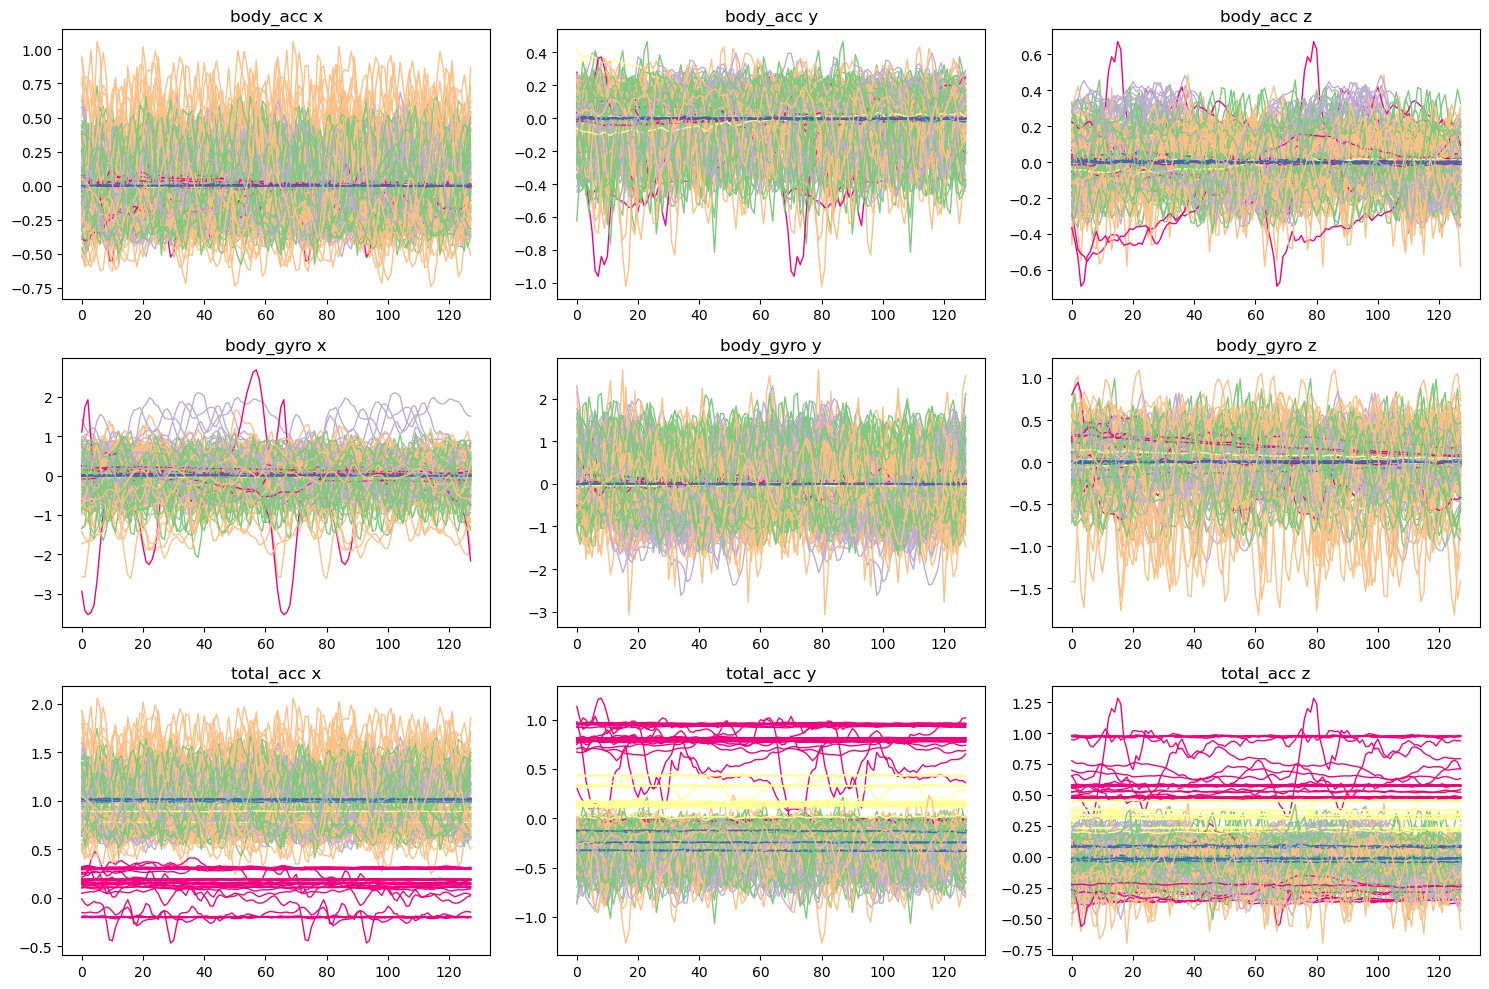

In [6]:
sample_to_plot = 50
index_per_act = [list(zip(np.repeat(act, sample_to_plot), np.where(Y_train_label==act)[0][:sample_to_plot])) for act in range(1,7)]
index_to_plot = list(itertools.chain.from_iterable(index_per_act))
random.shuffle(index_to_plot)

fig = plt.figure(figsize=(15,10))
for isignal in range(9):
    ax = fig.add_subplot(3,3,isignal+1)
    for act , i in index_to_plot:
        ax.plot(range(128), X_train[i,:,isignal],color=CMAP(act-1), linewidth=1)
        ax.set_title(SIGNALS[isignal])
plt.tight_layout()

**Note:** Appreciate the difficulty of distinguishing activities within a signal.

### 3.3 By signal 
The single signal "acceleration in x" is plotted by distinguishing activities.

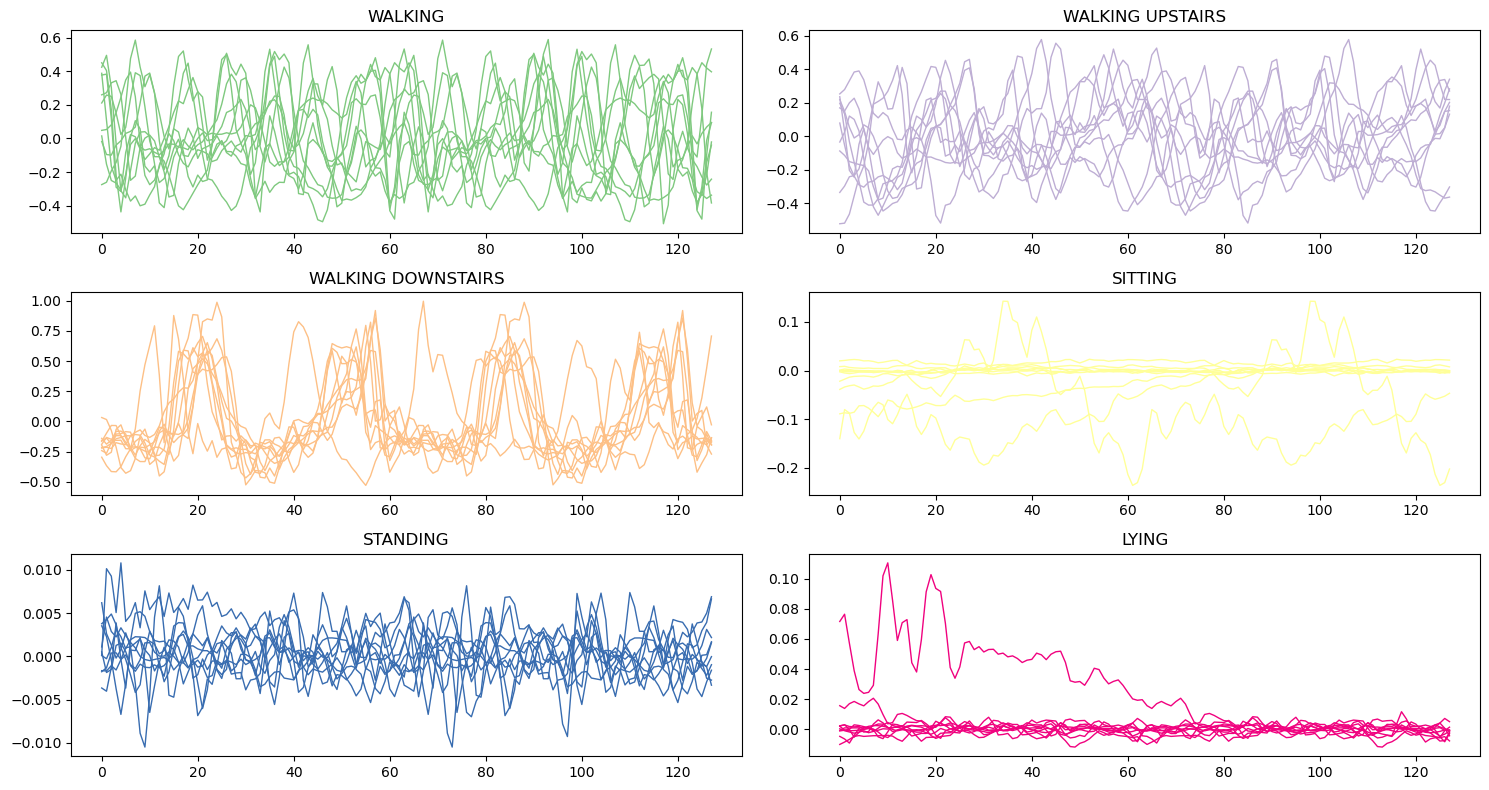

In [7]:
sample_to_plot = 10
isignal = 1
index_per_act_dict = dict([(act, np.where(Y_train_label==act)[0][:sample_to_plot]) for act in range(1,7)])


fig = plt.figure(figsize=(15,8), num=SIGNALS[isignal])
for act , index in index_per_act_dict.items():
    ax = fig.add_subplot(3,2,act)
    for x in X_train[index]:
        ax.plot(range(128), x[:,0],color=CMAP(act-1), linewidth=1)
    ax.set_title(ACTIVITY_DIC[act])
plt.tight_layout()

**Q.** Which activity seems to be distinguished easily from the others? 

**Q.** Observe the signals of an activity, for example `Walking upstairs`. What is it about these signals or curves that makes a classical Euclidean metric ($L_2$) inoperative? 

This is the reason why it will be important to decompose in particular the signals in the frequency domain. 


### 3.4 [Principal component analysis](http://wikistat.fr/pdf/st-m-explo-acp.pdf)
It is important to get a clear picture of the structure of the data.  A principal component analysis is suitable for this purpose. 
#### Notes
   - PCA is not reduced on these data because this transformation has no effect on the poor quality of the graphs.
   - The PCA based on a usual Euclidean metric only confirms the difficulties previously identified and the lack of discriminating power of the raw data in the sense of this metric; this exploration is not deepened on these data. On the other hand, another [notebook](https://github.com/wikistat/Exploration/blob/master/HumanActivityRecognition/Explo-Python-Har-brutes.ipynb) details a discriminant factor analysis but with the same conclusion.


The function defined below displays a point cloud in a factorial plane.

In [8]:
def plot_pca(X_R, ytrain, fig, ax, nbc, nbc2, label_dic=ACTIVITY_DIC, cmaps = plt.get_cmap("Accent")
):
    for i in range(6):
        xs = X_R[ytrain==i+1,nbc-1]
        ys = X_R[ytrain==i+1, nbc2-1]
        label = label_dic[i+1]
        color = cmaps(i)
        ax.scatter(xs, ys, color=color, alpha=.8, s=10, label=label)
        ax.set_xlabel("PC%d : %.2f %%" %(nbc,pca.explained_variance_ratio_[nbc-1]*100), fontsize=15)
        ax.set_ylabel("PC%d : %.2f %%" %(nbc2,pca.explained_variance_ratio_[nbc2-1]*100), fontsize=15)

####  PCA on a signal type

In [9]:
from sklearn.decomposition import PCA
pca = PCA()
# Choice of the signal
isignal = 4
signal = SIGNALS[isignal]
print("ACP Sur signal : " +signal)
X_c = pca.fit_transform(X_train[:,:,isignal])

ACP Sur signal : body_gyro y


Representation of the shares of variance explained by the first principal components.

Text(0.5, 0.98, 'Résultat ACP sur Signal : body_gyro y')

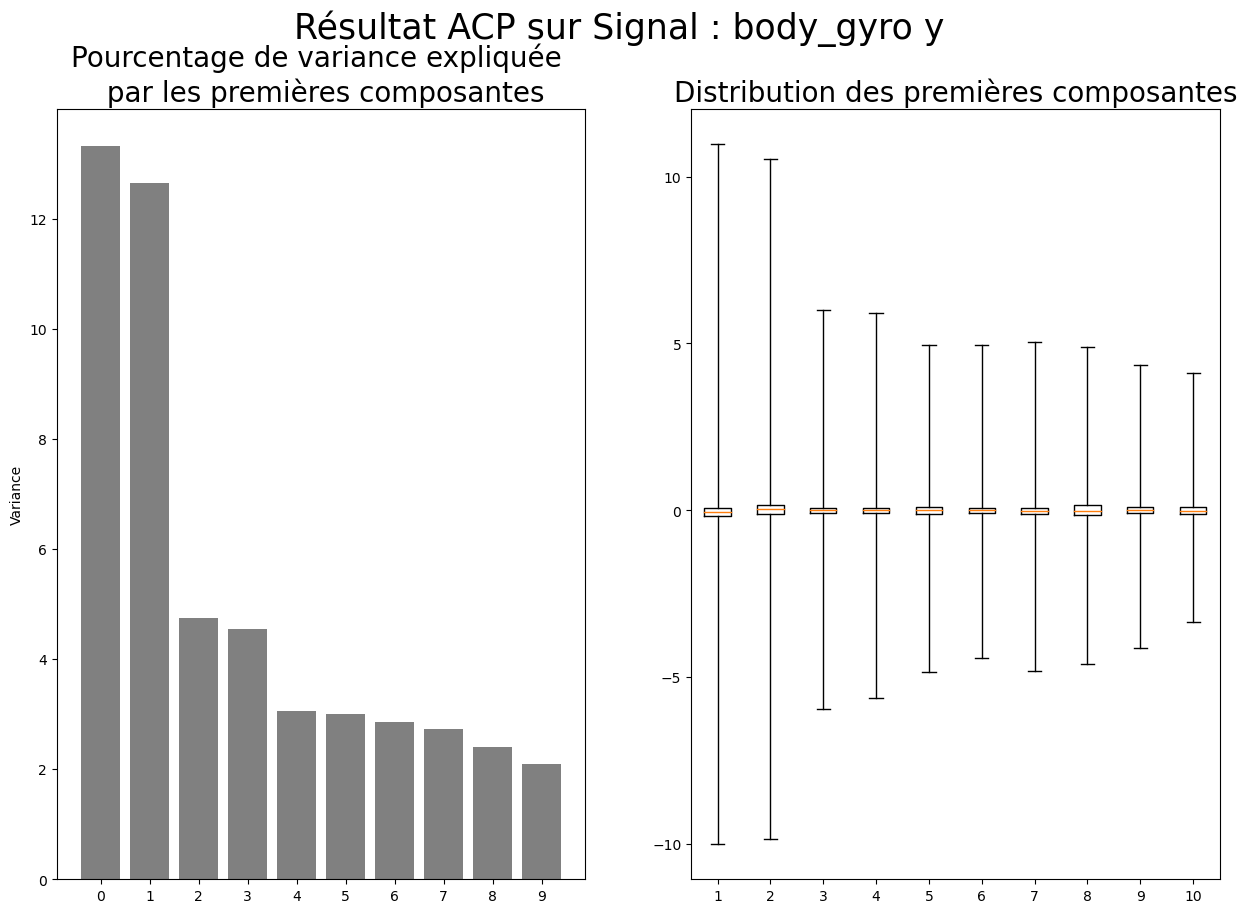

In [10]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), pca.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("", fontsize=35)
ax.set_title(u"Pourcentage de variance expliquée \n par les premières composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_c[:,0:10],whis=100)
ax.set_title(u"Distribution des premières composantes", fontsize=20)

fig.suptitle(u"Résultat ACP sur Signal : " + signal, fontsize=25)

**Warning**: the box plots are very disturbed by the distributions of the components with a very high concentration around 0 and a lot of atypical values. Hence the use of the `whis=100` parameter to lengthen the whiskers.

**Question** What are the graphs above? What interpretations or lack of interpretation can be drawn from them?

**Representation of the first factorial design:**

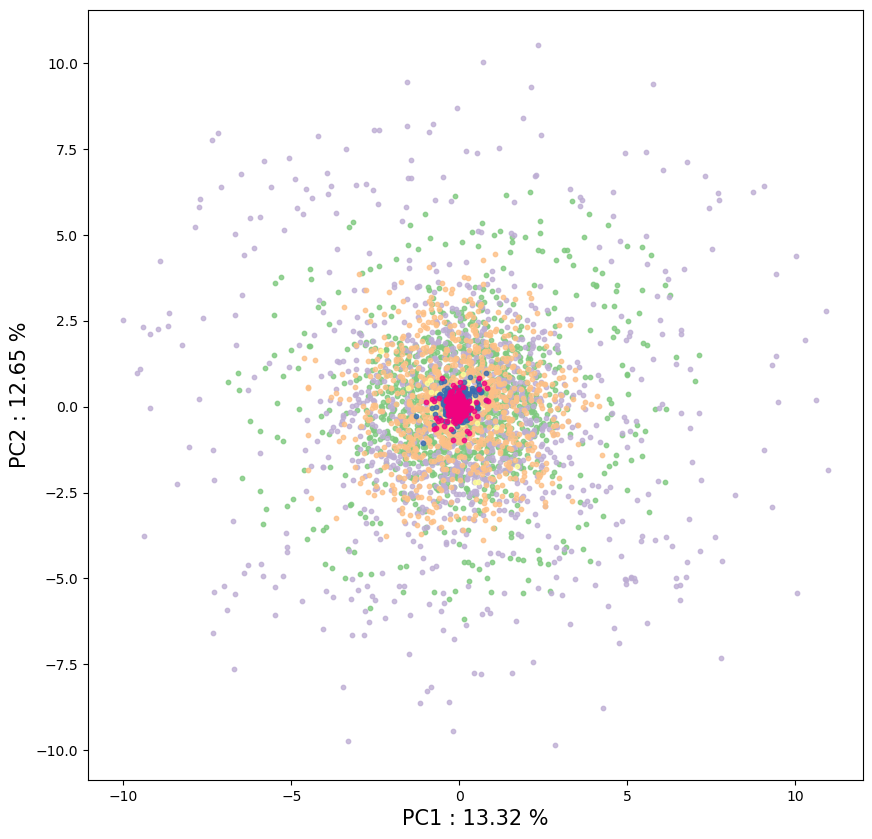

In [11]:
fig = plt.figure(figsize=(10,10), )
ax = fig.add_subplot(1,1,1)
plot_pca(X_c, Y_train_label,fig ,ax ,1 ,2)

The other factorial designs are not much more informative.
#### On all signals
All signals are concatenated flat into a single signal.

In [12]:
pca = PCA()
print("ACP Sur tous les signaux")
X_c = pca.fit_transform(X_train_flatten)

ACP Sur tous les signaux


Text(0.5, 0.98, 'Résultat ACP')

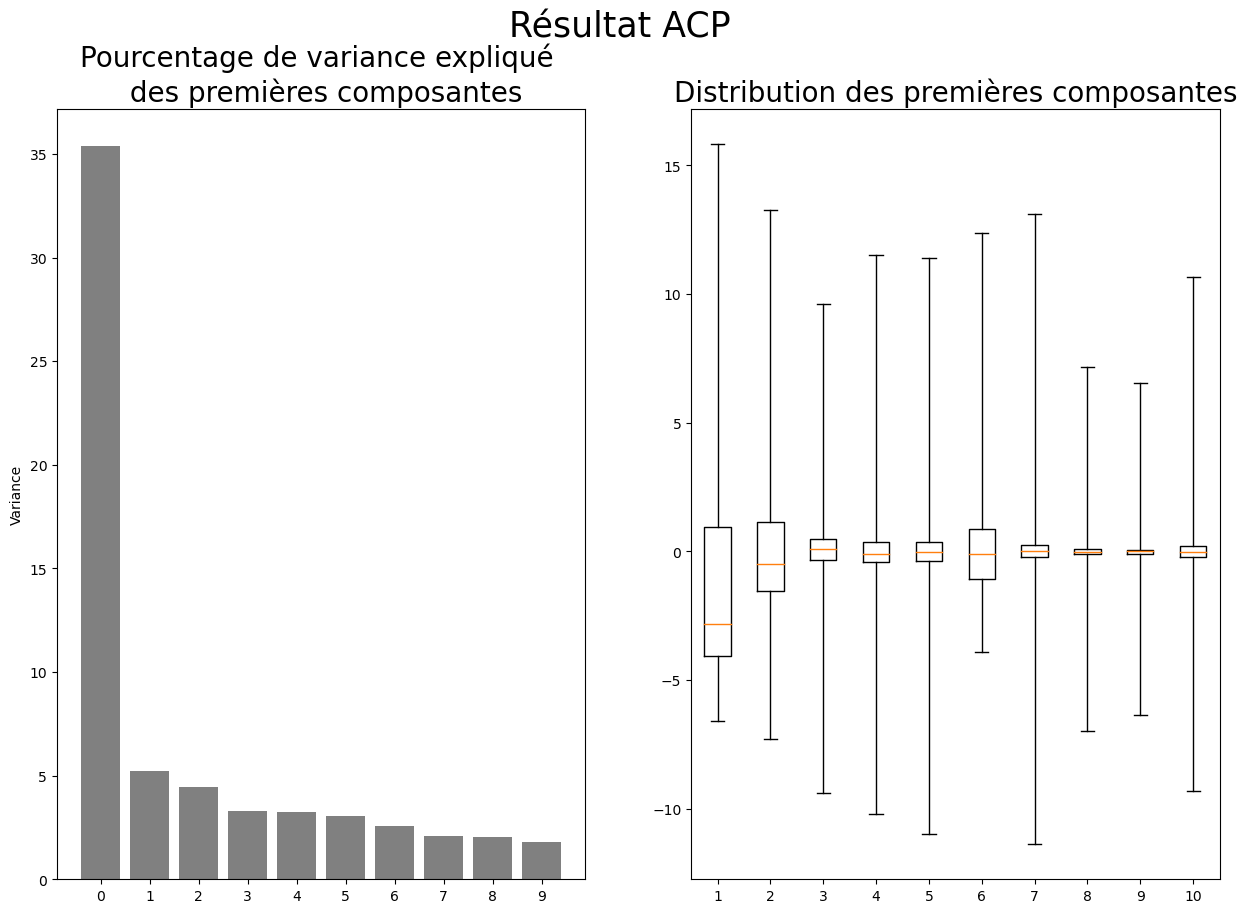

In [13]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,2,1)
ax.bar(range(10), pca.explained_variance_ratio_[:10]*100, align='center',
        color='grey', ecolor='black')
ax.set_xticks(range(10))
ax.set_ylabel("Variance")
ax.set_title("", fontsize=35)
ax.set_title(u"Pourcentage de variance expliqué \n des premières composantes", fontsize=20)

ax = fig.add_subplot(1,2,2)
box=ax.boxplot(X_c[:,0:10],whis=100)
ax.set_title(u"Distribution des premières composantes", fontsize=20)

fig.suptitle(u"Résultat ACP", fontsize=25)

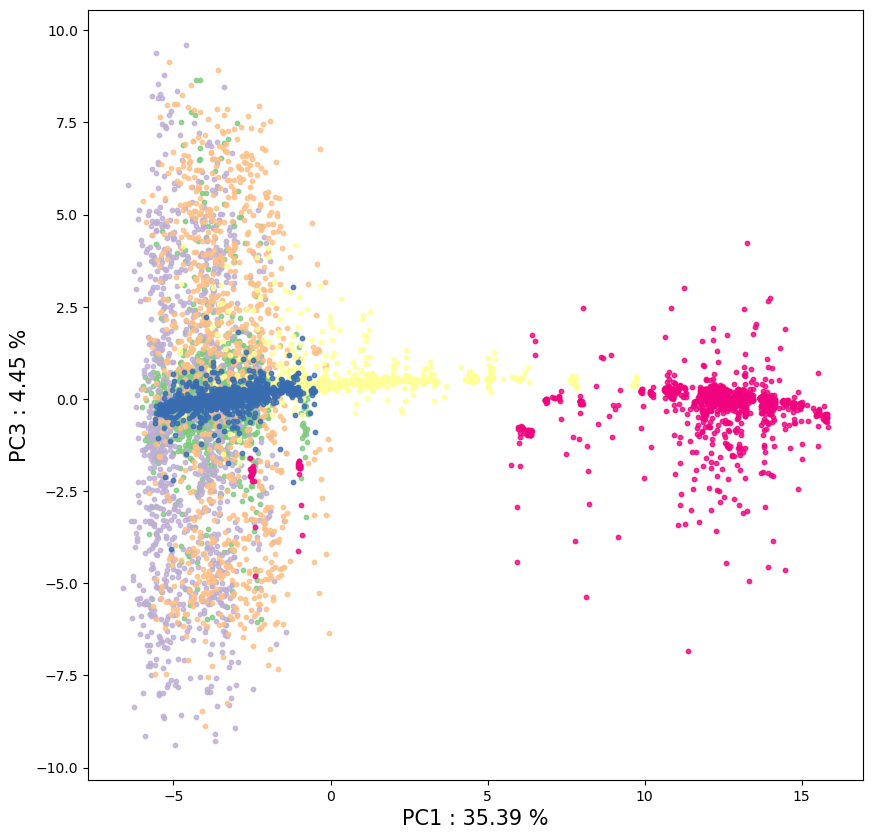

In [14]:
fig = plt.figure(figsize=(10,10), )
ax = fig.add_subplot(1,1,1)
plot_pca(X_c, Y_train_label,fig ,ax ,1 ,3)

**Question** Which activity seems easy to identify ?

## 3  Exploration of the features
### 3.1 The data
The [UCI archive]() also contains two files `train` and `test` of the 561 features, variables computed in the time and frequency domains by transforming the raw signals.

Here is an indicative list of the variables computed on each of the raw signals or pairs of signals:

Name|Signification
-|-
mean | Mean value
std | Standard deviation
mad | Median absolute value
max | Largest values in array
min | Smallest value in array
sma | Signal magnitude area
energy | Average sum of the squares
iqr | Interquartile range
entropy | Signal Entropy
arCoeff | Autorregresion coefficients
correlation | Correlation coefficient
maxFreqInd | Largest frequency component
meanFreq | Frequency signal weighted average
skewness | Frequency signal Skewness
kurtosis | Frequency signal Kurtosis
energyBand | Energy of a frequency interval
angle | Angle between two vectors

#### Reading the features data

In [15]:
# Reading the training data
# Attention, there can be several spaces as separator in the file
Xtrain=pd.read_csv("X_train.txt",sep='\s+',header=None)
Xtrain.head()

0         1         2         3         4         5         6    \
0  0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1  0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2  0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3  0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4  0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   

        7         8         9    ...       551       552       553       554  \
0 -0.983185 -0.923527 -0.934724  ... -0.074323 -0.298676 -0.710304 -0.112754   
1 -0.974914 -0.957686 -0.943068  ...  0.158075 -0.595051 -0.861499  0.053477   
2 -0.963668 -0.977469 -0.938692  ...  0.414503 -0.390748 -0.760104 -0.118559   
3 -0.982750 -0.989302 -0.938692  ...  0.404573 -0.117290 -0.482845 -0.036788   
4 -0.979672 -0.990441 -0.942469  ...  0.087753 -0.351471 -0.699205  0.123320   

        555       556       557       558       559       560  
0  0.030400 -0.464761 -0.018446 -0.841247  0.179941 -0.058627  
1 -0.007435 -0.732626  0.703511 -0.844788  0.180289 -0.054317  
2  0.177899  0.100699  0.808529 -0.848933  0.180637 -0.049118  
3 -0.012892  0.640011 -0.485366 -0.848649  0.181935 -0.047663  
4  0.122542  0.693578 -0.615971 -0.847865  0.185151 -0.043892  

[5 rows x 561 columns]

In [16]:
# Target variable 
ytrain=pd.read_csv("y_train.txt",sep='\s+',header=None,names=['y'])
# The dataFrame type is useless and even embarrassing for the following
ytrain=ytrain["y"]

In [17]:
# Reading the test data
Xtest=pd.read_csv("X_test.txt",sep='\s+',header=None)
Xtest.shape
ytest=pd.read_csv("y_test.txt",sep='\s+',header=None,names=['y'])
ytest=ytest["y"]

### 3.2 [Principal Component Analysis](http://wikistat.fr/pdf/st-m-explo-acp.pdf)
Graphical function for factorial designs.

In [18]:
def plot_pca(X_R,fig,ax,nbc,nbc2):
    for i in range(6):
        xs = X_R[ytrain==i+1,nbc-1]
        ys = X_R[ytrain==i+1, nbc2-1]
        label = ACTIVITY_DIC [i+1]
        color = cmaps(i)
        ax.scatter(xs, ys, color=color, alpha=.8, s=1, label=label)
        ax.set_xlabel("PC%d : %.2f %%" %(nbc,pca.explained_variance_ratio_[nbc-1]*100), fontsize=10)
        ax.set_ylabel("PC%d : %.2f %%" %(nbc2,pca.explained_variance_ratio_[nbc2-1]*100), fontsize=10)

Computation of the principal components matrix. It is also a change of basis; from the canonical basis to the basis of eigenvectors. 

In [19]:
pca = PCA()
X_c = pca.fit_transform(Xtrain)

#### Eigenvalues or variance of principal components
Representation of the decay of the eigenvalues, the variances of the variables or principal components.

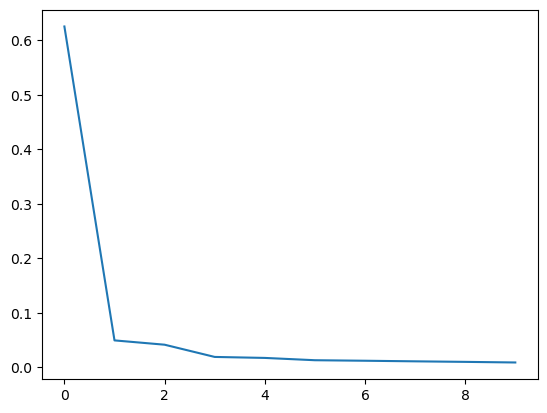

In [20]:
plt.plot(pca.explained_variance_ratio_[0:10])
plt.show()

A more explicit graph describes the distributions of these components by box plots; only the former are displayed. 

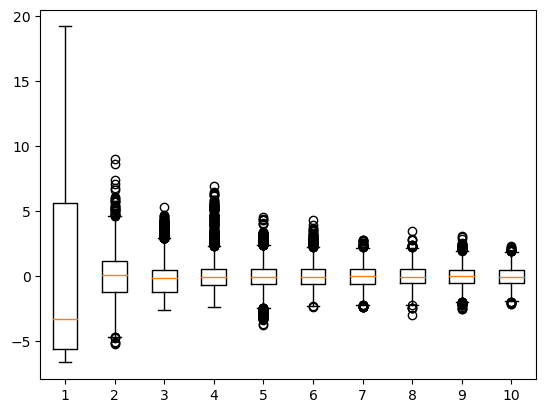

In [21]:
plt.boxplot(X_c[:,0:10])
plt.show()

Comment on the decrease in variances, the possible choice of a dimension or number of components to retain out of the 561.
#### Representation of individuals or "activities" in PCA
Projection in the main factorial plans.

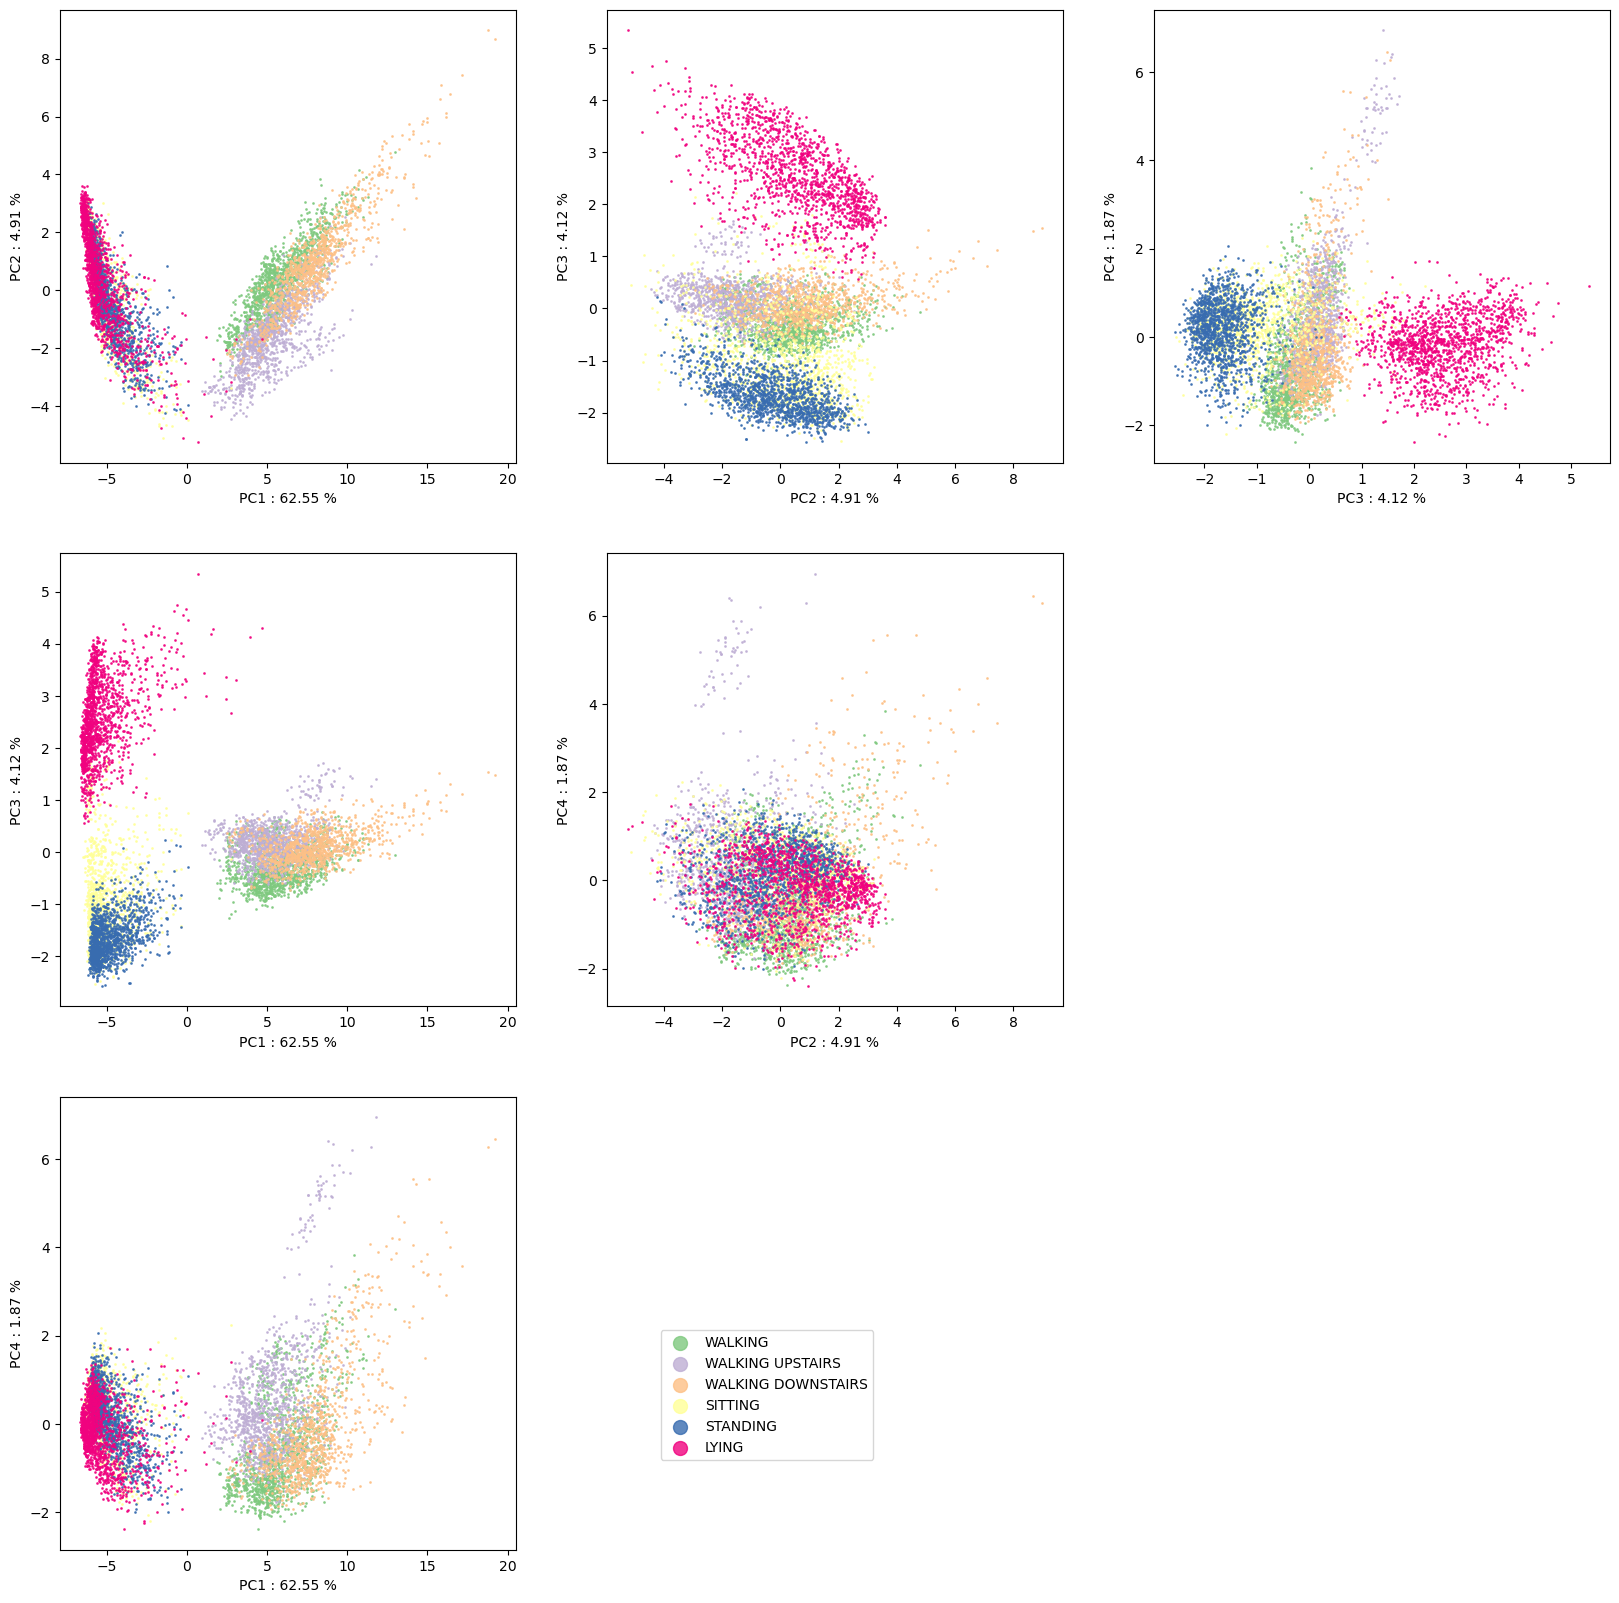

In [22]:
cmaps = plt.get_cmap("Accent")
fig = plt.figure(figsize= (20,20))
count = 0
for nbc, nbc2,count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    plot_pca(X_c, fig,ax,nbc,nbc2)
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 0.5), markerscale=10)
plt.show()

**Q** Comment on the separation of the two types of situations by the first axis.

**Q** What can you say about the shape of the clouds?

**Q.** What can you say about the separation of the classes?
#### Representation of the variables in PCA
Reading the labels of the variables and making a list. Because of the large dimension (561, the representations are not very usable. 

In [23]:
with open('features.txt', 'r') as content_file:
    featuresNames = content_file.read()
columnsNames = list(map(lambda x : x.split(" ")[1],featuresNames.split("\n")[:-1]))

Graph of variables unreadable by putting the labels in clear. Only a * is shown.

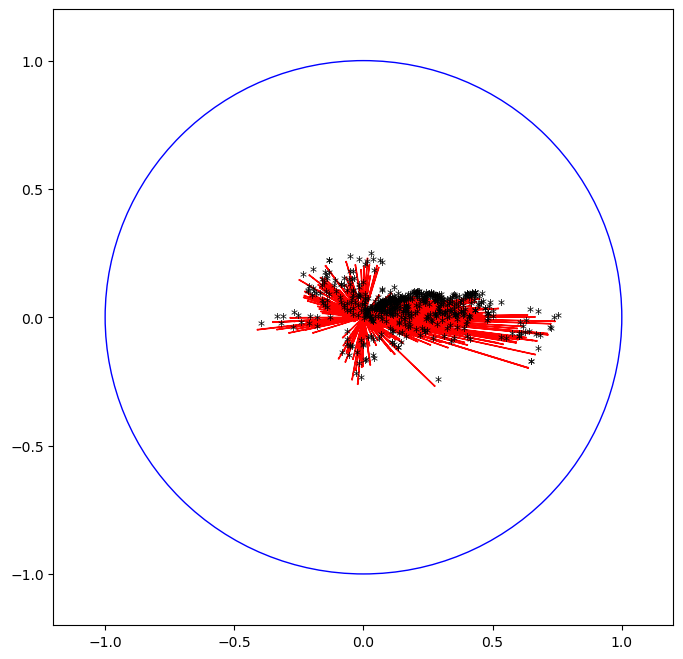

In [24]:
# coordinates of the variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j in zip(coord1,coord2, ):
    plt.text(i, j, "*")
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
plt.show()

Identification of the variables participating most in the first axis. It is not clearer! Only the representation of the individuals finally brings elements of understanding.

In [25]:
print(np.array(columnsNames)[abs(coord1)>.6])

['tBodyAccJerk-entropy()-X' 'tBodyAccJerk-entropy()-Y'
 'tBodyAccMag-entropy()' 'tGravityAccMag-entropy()'
 'tBodyAccJerkMag-entropy()' 'tBodyGyroJerkMag-entropy()'
 'fBodyAcc-entropy()-X' 'fBodyAcc-entropy()-Y' 'fBodyAcc-entropy()-Z'
 'fBodyAccJerk-entropy()-X' 'fBodyAccJerk-entropy()-Y'
 'fBodyAccJerk-entropy()-Z' 'fBodyAccMag-entropy()'
 'fBodyBodyAccJerkMag-entropy()' 'fBodyBodyGyroJerkMag-entropy()']


### 3.3 [Factorial Discriminant Analysis (FDA)](http://wikistat.fr/pdf/st-m-explo-afd.pdf)
#### Principle
PCA does not take into account the presence of the qualitative variable to be modeled, contrary to the Factorial Disciminant Analysis (FDA) adapted to this "supervised" context since the activity is known on a learning sample. The FDA is a PCA of the barycenters of the classes providing the space of the individuals with a specific metric called *Mahalanobis*. This metric is defined by the inverse of the intraclass covariance matrix. The objective is then to visualize the capacities of the variables to discriminate the classes.

The `scikit-learn` library does not propose a specific function of discriminant factorial analysis but the coordinates of the individuals in the basis of the discriminant vectors are obtained as results of the decisional linear discriminant analysis. This last one will be used with a predictive purpose in a second time (other notebook). 

The results of the `LinearDiscriminantAnalysis` function of `scikit-learn` are identical to those of the `lda` function of R. It is thus used strictly in the same way.

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
method = LinearDiscriminantAnalysis() 
lda=method.fit(Xtrain,ytrain)
X_r2=lda.transform(Xtrain)

**Q.** What does *warning* mean? What processing would be required to use decision discriminant analysis in modeling or learning?

#### Representation of individuals in FDA


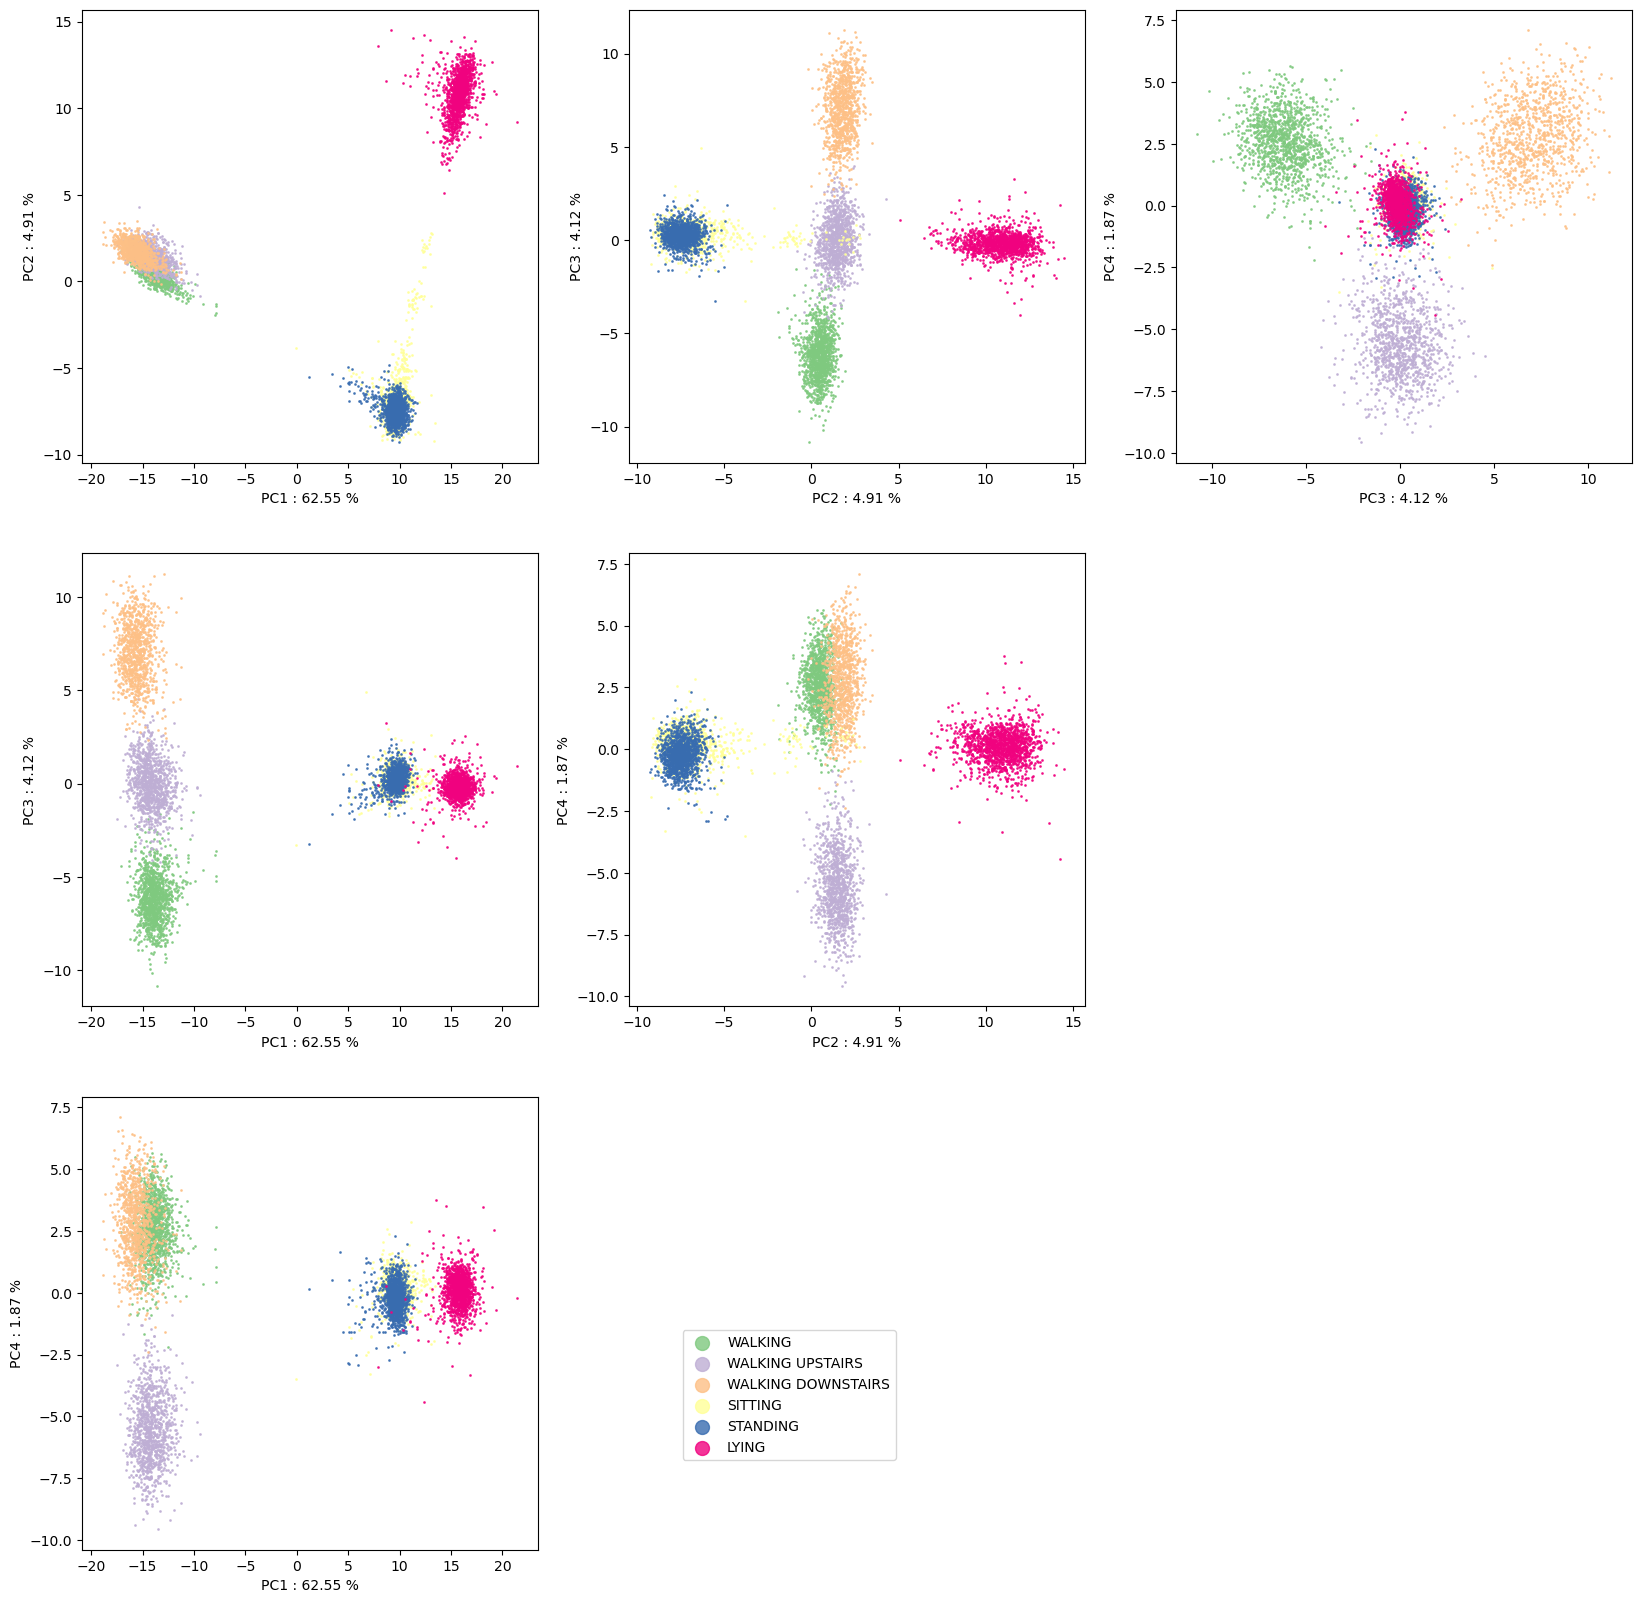

In [27]:
fig = plt.figure(figsize= (20,20))
count = 0
for nbc, nbc2,count in [(1,2,1), (2,3,2), (3,4,3), (1,3,4), (2,4,5), (1,4,7)] :
    ax = fig.add_subplot(3,3,count)
    plot_pca(X_r2, fig,ax,nbc,nbc2)
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 0.5), markerscale=10)
plt.show()

**Q.** What about the separation of classes? Are they all separable two by two ?

**Q.** What about the shape of the clouds, especially in the first plane ?

As for the PCA, the representation of the variables is too complex and would not be useful.

### 3.4 [Unsupervised classification](http://wikistat.fr/pdf/st-m-explo-classif.pdf)
This section is not useful since the classes are known. Nevertheless, a general approach to the study of signals relating to unidentified human activities *a priori* would require this unsupervised classification or *clustering* phase. This step simply illustrates the behavior of a classical unsupervised classification algorithm. The confusion matrix of the obtained classes with the known classes allows to evaluate the performance of the algorithm. 
#### $k$*-means*
Beware, it is necessary to center and reduce the variables before running an unsupervised classification algorithm.

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
tps1 = time.perf_counter()
X = StandardScaler().fit_transform(Xtrain)
km=KMeans(n_clusters=6)
km.fit(Xtrain)
tps2 = time.perf_counter()
print("Temps execution Kmeans :", (tps2 - tps1))

/usr/local/insa/anaconda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Temps execution Kmeans : 1.5998087119996853


In [29]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(ytrain, km.labels_)[1:7,0:6].T, columns=labels)

WALKING  WALKING UPSTAIRS  WALKING DOWNSTAIRS  SITTING  STANDING  LYING
0        0                 0                   0      308       413    163
1       85                49                 227        0         0      0
2        0                 0                   0      928       961      0
3      550               217                 625        0         0      0
4        0                 0                   0       49         0   1234
5      591               807                 134        1         0     10

**Q.** What about the effectiveness of an unsupervised approach to categorizing activities?

# <FONT COLOR="Red">Episode 2</font>

The PCA based on a usual Euclidean metric only confirms the difficulties previously identified and the lack of discriminating power of the raw data in the sense of this metric; this exploration is not deepened on these data. On the other hand, another notebook details a discriminant factor analysis but with the same conclusion.## 4 Activity prediction from the features 
Several methods are successively tested in this notebook: SVM, decision discriminate analysis, $k$ nearest neighbors, random forests, neural networks... We start with logistic regression for behavior prediction.

### 4.1 [Logistic regression](http://wikistat.fr/pdf/st-m-app-rlogit.pdf)

#### Principle
An old statistical method but finally efficient on these data. Logistic regression is adapted to the prediction of a binary variable. In the multiclass case, the logistic function of the `Scikit-learn` library estimates *by default* **a model by class**: one class against the others. 

The probability of an individual belonging to a class is modeled using a linear combination of the explanatory variables. To transform a linear combination with value in $\mathbb{R}$ into a probability with value in the interval $[0, 1]$, a sigmoidal function is applied.  This gives: $$P(y_i=1)=\frac{e^{Xb}}{1+e^{Xb}}$$ or, equivalently, a linear decomposition of the *logit* or *log odd ratio* of $P(y_i=1)$: $$\log\frac{P(y_i=1)}{1-P(y_i=1)}=Xb.$$


#### Estimation of the model without optimization
The model is estimated without trying to refine the values of some parameters (penalization). This will be done in a second step. The parameter of choice of the *solver* is specified because the default choice (`lbfgs`) seems to converge less quickly. A systematic comparison of the different options (`liblinear, lbfgs, saga, sag, newton-cg`) would be welcome in association with the choice of the model when the number of classes is greater than 2 : multinomial loss function or a binomial model per class.


In [30]:
from sklearn.linear_model import LogisticRegression
ts = time.time()
method = LogisticRegression(solver='liblinear',multi_class='auto')
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()

#### Predicting the activity of the test sample
Once the model has been estimated, the prediction error is evaluated, without optimistic bias, on another sample, the so-called test sample, which did not participate in the training of the model.

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

Score : 0.961995, time running : 4 secondes


WALKING  WALKING UPSTAIRS  WALKING DOWNSTAIRS  SITTING  \
WALKING                 494                 0                   2        0   
WALKING UPSTAIRS         23               448                   0        0   
WALKING DOWNSTAIRS        4                 9                 407        0   
SITTING                   0                 4                   0      432   
STANDING                  2                 0                   0       13   
LYING                     0                 0                   0        0   

                    STANDING  LYING  
WALKING                    0      0  
WALKING UPSTAIRS           0      0  
WALKING DOWNSTAIRS         0      0  
SITTING                   55      0  
STANDING                 517      0  
LYING                      0    537

**Q.** Which classes are still difficult to discriminate?

**Q.** Comment on the quality of the results obtained. Are they consistent with the exploratory approach?

#### Optimization of the model by Lasso penalization
*Warning* the execution is a bit long... this optimization can be omitted in the first reading.


In [32]:
# Optimisation of the penalisation parameter
# grid of values
from sklearn.model_selection import GridSearchCV
ts = time.time()
param=[{"C":[0.5,1,5,10,12,15,30]}]
logit = GridSearchCV(LogisticRegression(penalty="l1",solver='liblinear', 
                                        multi_class='auto'), param,cv=10,n_jobs=-1)
logitOpt=logit.fit(Xtrain, ytrain)  
# optimal parameter
logitOpt.best_params_["C"]
te = time.time()
print("Temps : %d secondes" %(te-ts))

Temps : 221 secondes


In [33]:
print("Meilleur score = %f, Meilleur paramètre = %s" % (logitOpt.best_score_,logitOpt.best_params_))

Meilleur score = 0.953622, Meilleur paramètre = {'C': 5}


In [34]:
yChap = logitOpt.predict(Xtest)
# confusion matrix
logitOpt.score(Xtest, ytest)

0.9647098744485918

In [35]:
pd.DataFrame(confusion_matrix(ytest, yChap), index = labels, columns=labels)

WALKING  WALKING UPSTAIRS  WALKING DOWNSTAIRS  SITTING  \
WALKING                 492                 2                   2        0   
WALKING UPSTAIRS         17               454                   0        0   
WALKING DOWNSTAIRS        4                 3                 413        0   
SITTING                   0                 5                   0      429   
STANDING                  2                 0                   0       12   
LYING                     0                 0                   0        0   

                    STANDING  LYING  
WALKING                    0      0  
WALKING UPSTAIRS           0      0  
WALKING DOWNSTAIRS         0      0  
SITTING                   56      1  
STANDING                 518      0  
LYING                      0    537

**Q.** Is the improvement significant with respect to the calculation time?

**Q.** Determine the variables selected by the LASSO method. 


### 4.2 [Linear Discriminant Analysis](http://wikistat.fr/pdf/st-m-app-add.pdf)

**Q.** What about the optimization of this method ? It is proposed in an R library but not available in Python.

**Q.** The quadratic discriminant analysis poses some problems. Why?


In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
ts = time.time()
method = LinearDiscriminantAnalysis()
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()
score

0.9623345775364778

In [37]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

Score : 0.962335, time running : 0 secondes


WALKING  WALKING UPSTAIRS  WALKING DOWNSTAIRS  SITTING  \
WALKING                 490                 6                   0        0   
WALKING UPSTAIRS         11               460                   0        0   
WALKING DOWNSTAIRS        1                14                 405        0   
SITTING                   0                 1                   0      434   
STANDING                  0                 0                   0       22   
LYING                     0                 0                   0        0   

                    STANDING  LYING  
WALKING                    0      0  
WALKING UPSTAIRS           0      0  
WALKING DOWNSTAIRS         0      0  
SITTING                   56      0  
STANDING                 510      0  
LYING                      0    537

### 4.3 [*K* nearest neighbors](http://wikistat.fr/pdf/st-m-app-add.pdf)

This method can be seen as a special case of discriminant analysis with local estimation of conditional density functions. 

**Q.** How many neighbors are used by default? Optimize this parameter. 

In [38]:
from sklearn.neighbors import KNeighborsClassifier
ts = time.time()
method = KNeighborsClassifier(n_jobs=-1)
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()
t_total = te-ts

In [39]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

Score : 0.901595, time running : 0 secondes


WALKING  WALKING UPSTAIRS  WALKING DOWNSTAIRS  SITTING  \
WALKING                 485                 2                   9        0   
WALKING UPSTAIRS         40               424                   7        0   
WALKING DOWNSTAIRS       45                45                 330        0   
SITTING                   0                 3                   0      389   
STANDING                  0                 0                   0       37   
LYING                     0                 0                   0        2   

                    STANDING  LYING  
WALKING                    0      0  
WALKING UPSTAIRS           0      0  
WALKING DOWNSTAIRS         0      0  
SITTING                   99      0  
STANDING                 495      0  
LYING                      1    534

### 4.4 [Linear SVM](http://wikistat.fr/pdf/st-m-app-svm.pdf)


The maximum number of iterations has been significantly increased (1000 by default) without improving the performance. The multi-class case is treated by considering one class against the others, thus 6 models.

**Q.** Use the default parameter and then vary the penalty parameter. 

In [40]:
from sklearn.svm import LinearSVC
ts = time.time()
method = LinearSVC(max_iter=20000)
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()
t_total = te-ts

In [41]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

Score : 0.966407, time running : 15 secondes


WALKING  WALKING UPSTAIRS  WALKING DOWNSTAIRS  SITTING  \
WALKING                 496                 0                   0        0   
WALKING UPSTAIRS         17               454                   0        0   
WALKING DOWNSTAIRS        2                 5                 413        0   
SITTING                   0                 4                   0      428   
STANDING                  1                 0                   0       11   
LYING                     0                 0                   0        0   

                    STANDING  LYING  
WALKING                    0      0  
WALKING UPSTAIRS           0      0  
WALKING DOWNSTAIRS         0      0  
SITTING                   57      2  
STANDING                 520      0  
LYING                      0    537

### 4.5 [SVM with Gaussian kernel](http://wikistat.fr/pdf/st-m-app-svm.pdf)

Learning with the default values and then optimize the parameters.

**Q.** What are the parameters to be optimized?

In [42]:
from sklearn.svm import SVC
ts = time.time()
method = SVC(gamma='auto')
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()

In [43]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

Score : 0.940278, time running : 6 secondes


WALKING  WALKING UPSTAIRS  WALKING DOWNSTAIRS  SITTING  \
WALKING                 492                 0                   4        0   
WALKING UPSTAIRS         17               452                   2        0   
WALKING DOWNSTAIRS       13                29                 378        0   
SITTING                   0                 2                   0      424   
STANDING                  0                 0                   0       44   
LYING                     0                 0                   0        0   

                    STANDING  LYING  
WALKING                    0      0  
WALKING UPSTAIRS           0      0  
WALKING DOWNSTAIRS         0      0  
SITTING                   65      0  
STANDING                 488      0  
LYING                      0    537

**Q.** Which procedure is executed below and for what purpose?

*Please note*: the execution is a bit long and can be skipped in the first reading.

In [44]:
ts = time.time()
param=[{"C":[4,5,6],"gamma":[.01,.02,.03]}]
svm= GridSearchCV(SVC(),param,cv=10,n_jobs=-1)
svmOpt=svm.fit(Xtrain, ytrain)
te = time.time()
te-ts

156.0195415019989

In [45]:
# optimal parameter
print("Meilleur score = %f, Meilleur paramètre = %s" % (svmOpt.best_score_,svmOpt.best_params_))

Meilleur score = 0.957704, Meilleur paramètre = {'C': 5, 'gamma': 0.02}


**Q.** Compare the two SVM approaches (linear and radial): computation time and performance.

### 4.6 [*Random forest*](http://wikistat.fr/pdf/st-m-app-agreg.pdf)

**Q.** What would be the parameter to optimize?

In [46]:
from sklearn.ensemble import RandomForestClassifier
ts = time.time()
method = RandomForestClassifier(n_estimators=200,n_jobs=-1)
method.fit(Xtrain,ytrain)
score = method.score(Xtest, ytest)
ypred = method.predict(Xtest)
te = time.time()
t_total = te-ts

In [47]:
print("Score : %f, time running : %d secondes" %(score, te-ts))
pd.DataFrame(confusion_matrix(ytest, ypred), index = labels, columns=labels)

Score : 0.926705, time running : 1 secondes


WALKING  WALKING UPSTAIRS  WALKING DOWNSTAIRS  SITTING  \
WALKING                 481                10                   5        0   
WALKING UPSTAIRS         34               430                   7        0   
WALKING DOWNSTAIRS       22                42                 356        0   
SITTING                   0                 0                   0      438   
STANDING                  0                 0                   0       43   
LYING                     0                 0                   0        0   

                    STANDING  LYING  
WALKING                    0      0  
WALKING UPSTAIRS           0      0  
WALKING DOWNSTAIRS         0      0  
SITTING                   53      0  
STANDING                 489      0  
LYING                      0    537

### 4.8 Combining models
The shapes of the clouds of each class observed in the first plane of the principal component analysis show that the covariance structure is not identical in each class. This remark would suggest that the quadratic discriminant analysis should be used, but it blocks on the estimation of the six covariance matrices and their inverse. Nevertheless, it seems that, more precisely, two groups can be distinguished: the active classes (walking, going up or down stairs) on the one hand and the passive classes (lying down, sitting down, standing up) on the other hand, and that, within each group, the variances are quite similar. 

This situation suggests the construction of a two-stage or hierarchical decision:
1. Logistic regression separating passive *vs.* active activities,
2. A model specific to each of the previous classes, e.g. Gaussian kernel SVMs.

Such a hierarchical model construction leads to an accuracy of more than 97%.

**Exercise:** Program such an approach using the capabilities of Python to make a *pipeline*.

# <FONT COLOR="Red">Episode 3</font>

## 5 Activity prediction from raw signals
### 5.1 Introduction
As explained in the introduction, the computation of numerous data transformations is far too consuming of the battery resources of a connected object. This section proposes to use only raw signals to learn an algorithm and among the possible algorithms, only neural networks that can be "wired" into a circuit are considered. We use here a multilayer perceptron. 


### 5.2 One hidden layer perceptron
#### Libraries 

In [48]:
import tensorflow as tf
import tensorflow.keras.models as km 
import tensorflow.keras.layers as kl

2024-03-22 11:52:52.152882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [49]:
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}
def my_confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

#### Definition of the network 
A hidden layer, a reformatting layer and an output layer with 6 classes. The number of neurons (50) on the hidden layer has been optimized elsewhere. The number of epochs and the size of the batches should be optimized especially in the case of using a GPU card.

Note the number of parameters to estimate.

In [50]:
epochs=20
batch_size=32
n_hidden = 50

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 6

model_base_mlp =km.Sequential()
model_base_mlp.add(kl.Dense(n_hidden, input_shape=(timesteps, input_dim),  activation = "relu"))
model_base_mlp.add(kl.Reshape((timesteps*n_hidden,) , input_shape= (timesteps, n_hidden)  ))
model_base_mlp.add(kl.Dense(n_classes, activation='softmax'))

model_base_mlp.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model_base_mlp.summary()

2024-03-22 11:53:06.427089: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128, 50)           500       
                                                                 
 reshape (Reshape)           (None, 6400)              0         
                                                                 
 dense_1 (Dense)             (None, 6)                 38406     
                                                                 
Total params: 38,906
Trainable params: 38,906
Non-trainable params: 0
_________________________________________________________________


In [ ]:
t_start = time.time()
model_base_mlp.fit(X_train,  Y_train_dummies, batch_size=batch_size, validation_data=(X_test, Y_test_dummies), epochs=epochs)
t_end = time.time()
t_learning = t_end-t_start

score = model_base_mlp.evaluate(X_test, Y_test_dummies)[1] 
print("\nScore With Simple MLP on Multidimensional Inertial Signals = %.2f, Learning time = %.2f secondes" %(score*100, t_learning) )
metadata_mlp = {"time_learning" : t_learning, "score" : score}
base_mlp_prediction = model_base_mlp.predict(X_test)

my_confusion_matrix(Y_test_dummies, base_mlp_prediction)

Epoch 1/20
230/230 [==============================] - 21s 90ms/step - loss: 0.5558 - accuracy: 0.7816 - val_loss: 0.6240 - val_accuracy: 0.7754
Epoch 2/20
230/230 [==============================] - 19s 82ms/step - loss: 0.2997 - accuracy: 0.8876 - val_loss: 0.5362 - val_accuracy: 0.8259
Epoch 3/20
230/230 [==============================] - 20s 86ms/step - loss: 0.2232 - accuracy: 0.9195 - val_loss: 0.5558 - val_accuracy: 0.8219
Epoch 4/20
230/230 [==============================] - 20s 86ms/step - loss: 0.1825 - accuracy: 0.9314 - val_loss: 0.5479 - val_accuracy: 0.8385
Epoch 5/20
230/230 [==============================] - 21s 89ms/step - loss: 0.1546 - accuracy: 0.9399 - val_loss: 0.5408 - val_accuracy: 0.8381
Epoch 6/20
230/230 [==============================] - 20s 87ms/step - loss: 0.1397 - accuracy: 0.9456 - val_loss: 0.5408 - val_accuracy: 0.8616
Epoch 7/20
230/230 [==============================] - 17s 73ms/step - loss: 0.1258 - accuracy: 0.9487 - val_loss: 0.5829 - val_accuracy:

**Q.** Does adding a hidden layer improve the results? 

A few more efforts would undoubtedly allow to gain a few points on the accuracy of the result but... beware of overfitting if the same test sample is always used. 

In the 5th year, in the UF High Dimensional and Deep Learning (HDDL), a convolutional network (CNN) on the signals will allow to obtain better performances, close to those obtained on the features. 
